In [12]:
# load package
# string 
import re

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# sys
import sys
import os
import time
import warnings

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# self define
sys.path.append('../../utils/')

In [13]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()
data1 = pd.concat([d1,d2,d3,d4,d5], 0)
d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()
data2 = pd.concat([d6,d7,d8,d9,d10], 0)
data = pd.concat([data1, data2], 0)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def to_count_table(df, cols):
    df['count'] = '1'
    df = df[[cols[0], 'count']]
    return df.groupby(cols[0], as_index = False).count().sort_values(by = 'count', ascending = False)

In [14]:
# 初衷是通过一个个的账单，统计每个属性，对应属性项在一段时间内出现的次数

def toFreqTable(df, att, date, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        date, string:
            the column name of the date attribute
    """
    # extract the att and date columns
    df = df[[att, date]]
    
    # change string date to date type
    # detect outlier
    fake = df[date].map(check_date)
    # if clean is True, drop the fake data
    if clean:
        print("Fake date exist, drop these dates directly")
        df = df.drop(df[fake].index)
    df[date] = pd.to_datetime(df[date])
    # add new column named 'count'
    df['count'] = pd.Series([1 for i in range(len(df))])
    # group and sum 
    df_g = df.groupby([date, att], as_index = False).agg({'count': 'sum'})
    return df_g

def check_date(s, sep = '.'):
    """
    only check the date grobly,
    set the fake date to True and the right date to false
    """
    items = s.split('.')
    #print(items)
    if len(items) <3:
        return True
    day = int(items[0])
    month = int(items[1])
    year = int(items[2])
    if day <= 31 and day > 0 and month <= 12 and month > 0 and year > 0:
        return False
    else:
        return True

In [17]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

### veiteilung analyse: Adressanredecode

In [281]:
av  = lb_wsp_2014[['Auftragsdatum', 'Adressanredecode']]

In [282]:
av['Adressanredecode'].loc[(av['Adressanredecode'] != 'Firma') & (av['Adressanredecode'] != 'Herr') & (av['Adressanredecode'] != 'Frau')] = 'other'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [283]:
to_count_table(av, ['Adressanredecode'])

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Adressanredecode,count
0,Firma,104481
2,Herr,83843
1,Frau,39669
3,other,7658


In [294]:
tmp = pd.DataFrame({'Firma':104481/235651, 'Herr':83843/235651, 'Frau':39669/235651, 'other':7658/235651}, index = ['count'])

In [296]:
tmp

,Firma,Frau,Herr,other
count,0.443372,0.168338,0.355793,0.032497


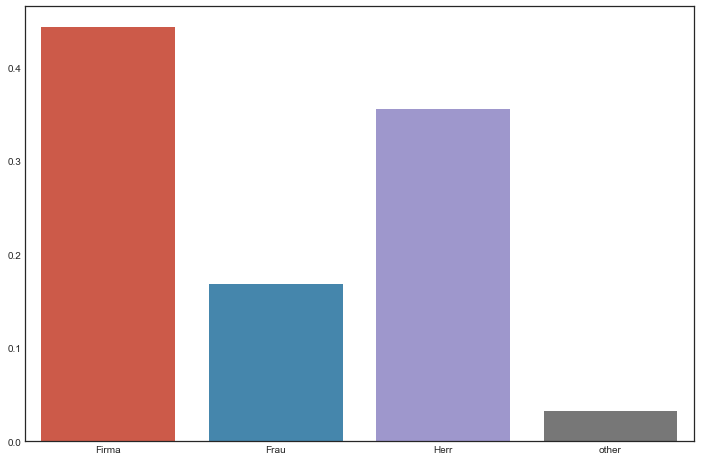

In [298]:
#f, ax = plt.subplots(1, figsize=(20,16))
sns.barplot(data = tmp)
#sns.barplot(data = tmp2, y = 'index', x = 'null count', ax = ax[0], color = '#95a5a6')

In [7]:
data2['Adressanredecode'].unique()

array(['Firma', 'Herr', 'Frau', nan, 'FA_F', 'OHNE', 'AN', 'AUTOHAUS',
       'HR.DR.', 'FAHRSCHULE', 'FA_M', 'FR.DR.', 'HERR+FRAU', 'PR',
       'FRAU+HERR', 'HE', 'FAMILIE', 'HERR UND F', 'FRAU U HER'], dtype=object)

In [247]:
data1.loc[data1['Adressanredecode'] == 'FR.DR.','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FA_F','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FR.PROF.','Adressanredecode'] = 'Frau'
data1.loc[data1['Adressanredecode'] == 'FA_M','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'HR.DR.','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'PR','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'HE','Adressanredecode'] = 'Herr'
data1.loc[data1['Adressanredecode'] == 'OHNE','Adressanredecode'] = 'unbekannt'
data1.loc[data1['Adressanredecode'] == 'AN','Adressanredecode'] = 'unbekannt'
data1.loc[data1['Adressanredecode'].isna(),'Adressanredecode'] = 'unbekannt'
data1.loc[data1['Adressanredecode'] == 'FAHRSCHULE','Adressanredecode'] = 'Firma'
data1.loc[data1['Adressanredecode'] == 'AUTOHAUS','Adressanredecode'] = 'Firma'
data1.loc[data1['Adressanredecode'] == 'HERR+FRAU','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'FRAU+HEER','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'FAMILIE','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'HERR UND F','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'FRAU U HER','Adressanredecode'] = 'Ehepaar'
data1.loc[data1['Adressanredecode'] == 'HR U. FR','Adressanredecode'] = 'Ehepaar'

In [248]:
data1['Adressanredecode'].value_counts()

Firma        531871
Herr         409923
Frau         202427
unbekannt     13535
Ehepaar         166
Name: Adressanredecode, dtype: int64

In [251]:
tmp = pd.DataFrame({'Firma':531871/1001054, 'Herr':409923/1157922, 'Frau':202427/1157922, 'Ehepaar': 166/1157922, 'Unbekannt':13535/1157922}, index = ['count'])

In [252]:
data1.loc[data1['Adressanredecode'] == 'Firma', 'Adressanredecode'].count()

531871

In [253]:
data1['Adressanredecode'].count()

1157922

[Text(0,0,'Ehepaar'),
 Text(0,0,'Firma'),
 Text(0,0,'Frau'),
 Text(0,0,'Herr'),
 Text(0,0,'Unbekannt')]

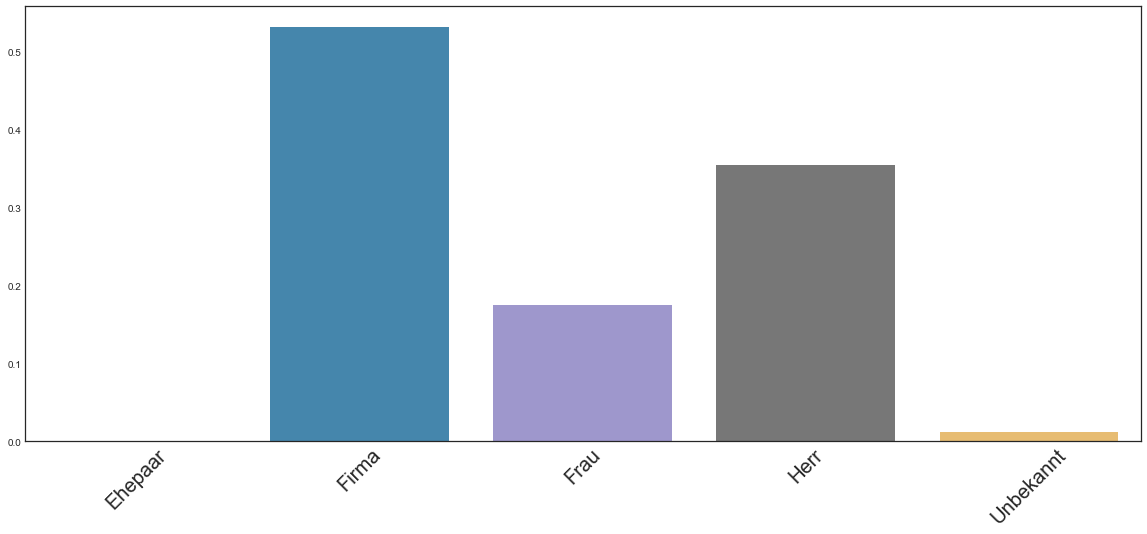

In [256]:
f, ax = plt.subplots(figsize = (20, 8))
sns.barplot(data = tmp)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 20)

### zeitreihe analyse: adressanredecode(einheit in Auftrag)

In [285]:
# to freq table
av_ref = toFreqTable(av, 'Adressanredecode', 'Auftragsdatum')

Fake date exist, drop these dates directly


In [286]:
av_ref.head()

,Auftragsdatum,Adressanredecode,count
0,1753-01-01,other,0.0
1,2013-12-30,Firma,2.0
2,2014-01-02,Firma,95.0
3,2014-01-02,Frau,14.0
4,2014-01-02,Herr,19.0


In [ ]:
a

In [173]:
# create full table 
def create(x):
    tmp = pd.DataFrame({'Adressanredecode': av_ref['Adressanredecode'].unique()})
    tmp['Auftragsdatum'] = x.iloc[0, 0]
    return tmp
av_new = av_ref.groupby('Auftragsdatum', as_index = False).apply(create)

In [174]:
av_new = av_new.reset_index()[['Auftragsdatum', 'Adressanredecode']]

In [175]:
# merge the table to the original one
av_full = pd.merge(av_ref, av_new, how = 'right')

In [176]:
av_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3780 entries, 0 to 3779
Data columns (total 3 columns):
Auftragsdatum       3780 non-null datetime64[ns]
Adressanredecode    3780 non-null object
count               1161 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 118.1+ KB


In [177]:
av_full = av_full.sort_values(by = 'Auftragsdatum')

In [221]:
tmp = av_full.copy()

聚合一个月的数据

In [222]:
tmp['count'] = tmp.iloc[:, 2].replace(np.nan,0)

In [238]:
tmp['month'] = tmp['Auftragsdatum'].map(lambda x: str(x)[5:7])

In [240]:
tmp['year'] = tmp['Auftragsdatum'].map(lambda x: str(x)[0:4])

In [246]:
tmp['date'] = tmp['year'] +'-'+ tmp['month']

In [251]:
df_agg = tmp.groupby(['date', 'Adressanredecode'], as_index = False).sum()

In [255]:
tmp[tmp['Adressanredecode'] == 'Firma']

,Auftragsdatum,Adressanredecode,count,month,year,date
0,2013-12-30,Firma,2.0,12,2013,2013-12
1,2014-01-02,Firma,95.0,01,2014,2014-01
4,2014-01-03,Firma,4.0,01,2014,2014-01
9,2014-01-04,Firma,525.0,01,2014,2014-01
1197,2014-01-05,Firma,0.0,01,2014,2014-01
1208,2014-01-06,Firma,0.0,01,2014,2014-01
15,2014-01-07,Firma,529.0,01,2014,2014-01
18,2014-01-08,Firma,205.0,01,2014,2014-01
22,2014-01-09,Firma,599.0,01,2014,2014-01
27,2014-01-10,Firma,346.0,01,2014,2014-01


In [193]:
str(tmp['Auftragsdatum'][0].to_pydatetime().year) 

'2013'

In [217]:
tmp['Date'] = tmp['Auftragsdatum'].astype(str)

In [219]:
tmp['Date'] = tmp['Date']

,Auftragsdatum,Adressanredecode,count,Date
0,2013-12-30,Firma,2.0,2013-12-30
1163,2013-12-30,OHNE,0.0,2013-12-30
1164,2013-12-30,AN,0.0,2013-12-30
1165,2013-12-30,FA_F,0.0,2013-12-30
1166,2013-12-30,FR.DR.,0.0,2013-12-30
1167,2013-12-30,FA_M,0.0,2013-12-30
1168,2013-12-30,HR.DR.,0.0,2013-12-30
1169,2013-12-30,AUTOHAUS,0.0,NaN
1170,2013-12-30,HERR+FRAU,0.0,NaN
1171,2013-12-30,FAHRSCHULE,0.0,NaN


In [262]:
lb_wsp_2014['Markencode'].unique()

array(['VW', 'SKODA', 'AUDI', nan, 'BMW', '27.04.2006', 'OPEL', 'SUBARU',
       'SEAT', 'RENAULT', 'TOYOTA', '13.08.2009', 'FORD', 'CITROËN',
       'MERCEDES', 'MAZDA', 'PORSCHE', 'CHRYSLER', 'PEUGEOT', '09.05.2005'], dtype=object)

### Anzhal von null wert

In [301]:
tmp = lb_wsp_2014[lb_wsp_2014['Markencode'] == 'AUDI']
tmp['Beschreibung'].describe()

count        74958
unique        5490
top       SCHRAUBE
freq          6108
Name: Beschreibung, dtype: object

要每个项的个数和空值个数的对比图像

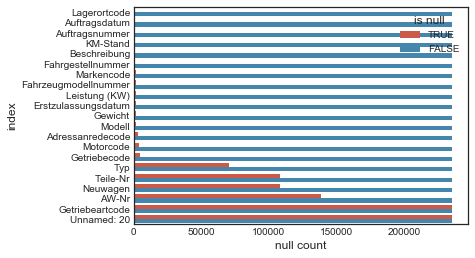

In [194]:
sns.barplot(data = tmp, y = 'index', x = 'null count', hue = 'is null').get_figure().savefig('/tmp/tmp.png')

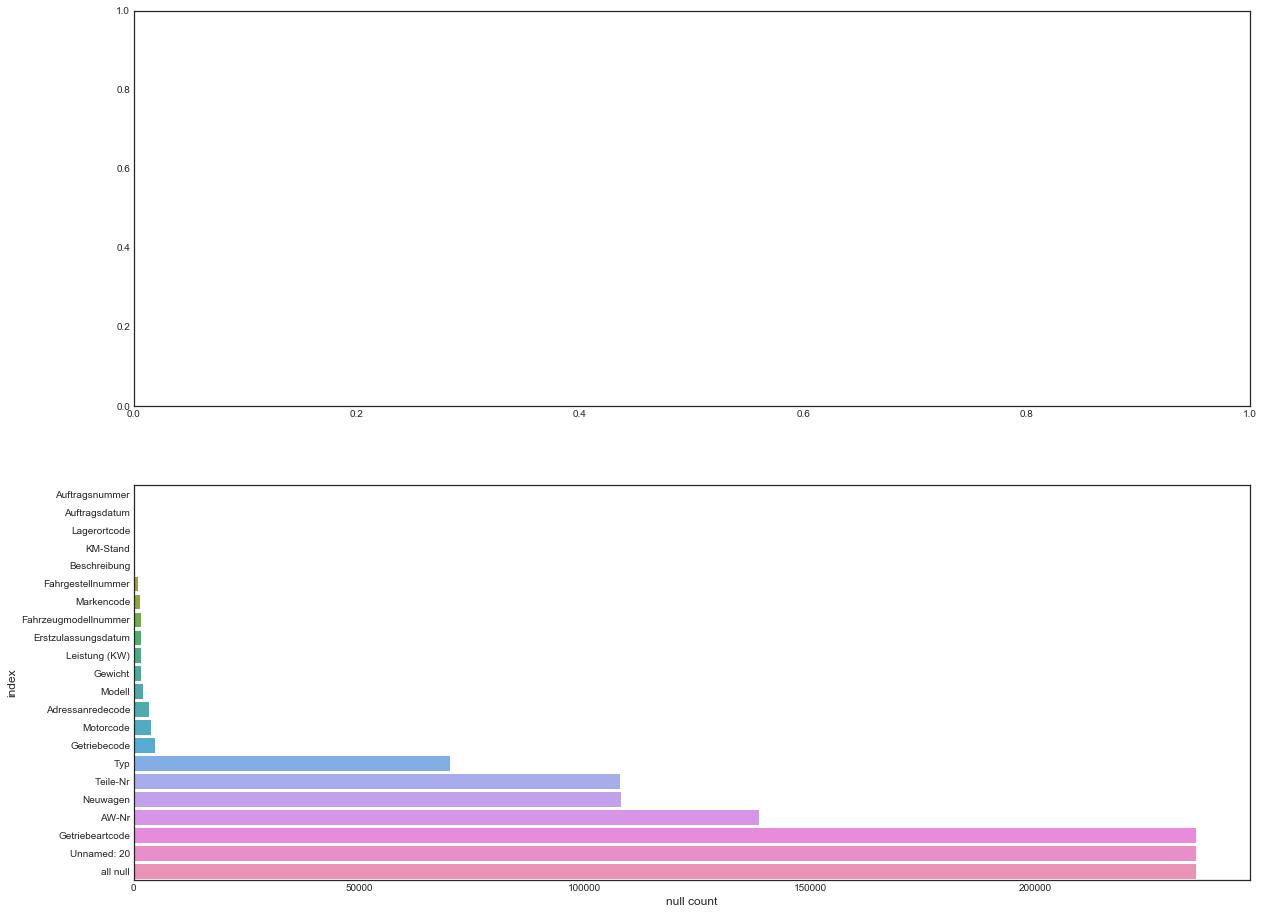

In [220]:
f, ax = plt.subplots(2, figsize=(20,16))
sns.barplot(data = tmp1, y = 'index', x = 'null count')
#sns.barplot(data = tmp2, y = 'index', x = 'null count', ax = ax[0], color = '#95a5a6')

In [218]:
tmp1.loc[21, 'index'] = 'all null'

In [219]:
tmp1

,index,null count,is null
0,Auftragsnummer,0.0,TRUE
5,Auftragsdatum,0.0,TRUE
7,Lagerortcode,0.0,TRUE
3,KM-Stand,73.0,TRUE
4,Beschreibung,125.0,TRUE
9,Fahrgestellnummer,1036.0,TRUE
6,Markencode,1501.0,TRUE
11,Fahrzeugmodellnummer,1562.0,TRUE
18,Erstzulassungsdatum,1635.0,TRUE
17,Leistung (KW),1635.0,TRUE


In [213]:
tmp = data[['Auftragsnummer', 'AW-Nr', 'Teile-Nr', 'KM-Stand', 'Beschreibung',
       'Auftragsdatum', 'Markencode', 'Lagerortcode', 'Adressanredecode',
       'Fahrgestellnummer', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell',
       'Getriebecode', 'Getriebeartcode', 'Gewicht',
       'Erstzulassungsdatum']].copy()

In [78]:
newcar = lb_wsp_2014[lb_wsp_2014['Auftragsnummer'] == 'WSAU224330']

In [216]:
len(tmp1)

22

### outlier in AW-Nr

In [228]:
fake = data['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))

In [230]:
data[fake]['AW-Nr'].unique()

array([nan, 'PX955500', 'PXISI710', ..., 'E130100', 'W+I', 'J46240008'], dtype=object)

In [231]:
tmp = data.copy()

In [232]:
tmp['count'] = 1

In [237]:
tmp[fake][['AW-Nr', 'count']].groupby('AW-Nr', as_index = False).count().sort_values(by = 'count', ascending = False)

,AW-Nr,count
735,LACK,1553
1016,TÜV,1092
333,EINLAGERUNG,488
278,E002530,333
918,P000400,295
579,J792600,150
958,S000131,103
963,S000133011,97
3,A0000000,90
556,J635100,77


### outlier in Markencode and distribution

In [108]:
tmp = data1.copy()
#tmp['count'] = 1
#tmp = tmp[['Markencode', 'count']]

In [109]:
fake = tmp['Markencode'].map(lambda x: bool(re.search('\d', str(x))))

In [110]:
#tmp.groupby('Markencode', as_index = False).count().sort_values(by = 'count', ascending = False)
tmp[fake][['Auftragsnummer', 'Markencode']]

,Auftragsnummer,Markencode
14067,103K,27.04.2006
14069,103K,27.04.2006
14071,103K,27.04.2006
23457,103K,27.04.2006
23459,103K,27.04.2006
23461,103K,27.04.2006
23463,103K,27.04.2006
23465,103K,27.04.2006
23467,103K,27.04.2006
23469,103K,27.04.2006


In [111]:
af = toAuftragTable(tmp, 'Markencode', 'Auftragsnummer')

Falls Null date exist, drop these dates directly


In [112]:
# drop outlier
af = af.drop(af[af['Markencode'].map(lambda x: bool(re.search('\d', str(x))))].index, axis=0)

In [113]:
af

,Markencode,Auftragsnummer
2,AUDI,WSAU000839
3,VW,WSAU195981
4,AUDI,WSAU198256
5,VW,WSAU200129
6,VW,WSAU200223
7,AUDI,WSAU200258
8,AUDI,WSAU200259
9,AUDI,WSAU200260
10,AUDI,WSAU200263
11,AUDI,WSAU200264


In [114]:
vc = af['Markencode'].value_counts()

In [115]:
vc.index

Index(['VW', 'AUDI', 'SKODA', 'nan', 'SEAT', 'MERCEDES', 'BMW', 'FORD', 'OPEL',
       'PORSCHE', 'RENAULT', 'DIV', 'MAZDA', 'CITROËN', 'FIAT', 'TOYOTA',
       'HYUNDAI', 'PEUGEOT', 'SUBARU', 'NISSAN', 'MCC SMART', 'KIA', 'JAGUAR',
       'ROVER', 'MITSUBISHI', 'DAF', 'CHRYSLER', 'ALFA'],
      dtype='object')

In [116]:
df_vc = pd.DataFrame({'Markencode':vc.index, 'count': vc.tolist()})

In [124]:
df_vc.head()

,Markencode,count
0,VW,43531
1,AUDI,27261
2,SKODA,13444
3,nan,1807
4,SEAT,293


In [128]:
print(df_vc[df_vc['count']<100]['count'].count()/df_vc['count'].count())
print(df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum())

0.821428571429
0.00339374350687


In [126]:
df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum()

0.0033937435068682902

Text(0.5,0,'Markencode')

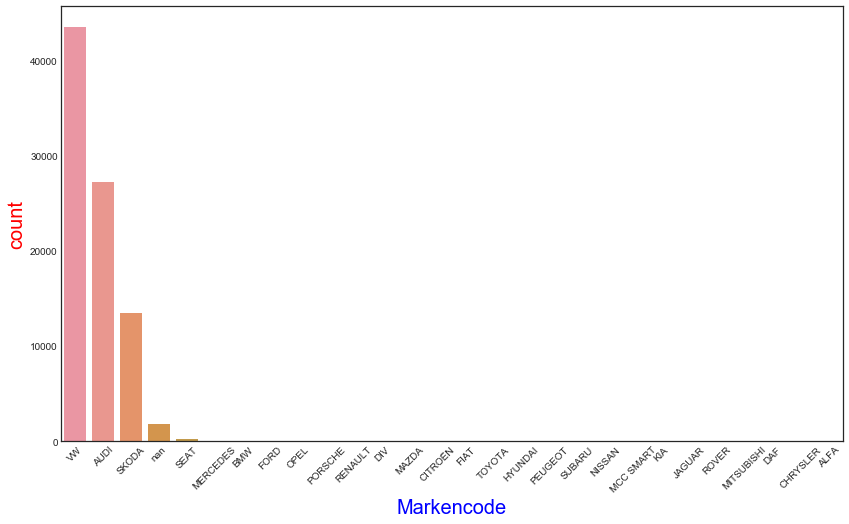

In [49]:
f, ax = plt.subplots(figsize = (14, 8))
sns.barplot(x = 'Markencode', y = 'count', data = df_vc, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel('Markencode', fontsize=20, color='b')

### zeitreihe-count plot

In [313]:
av_ref = toFreqTable(tmp, 'Adressanredecode', 'Auftragsdatum')

Fake date exist, drop these dates directly


In [314]:
tmp = av_ref[['Auftragsdatum', 'count']].groupby('Auftragsdatum').sum()

In [315]:
tmp = av_ref[['Auftragsdatum', 'count']].groupby('Auftragsdatum', as_index = False).sum()

In [321]:
tmp['date'] = tmp['Auftragsdatum'].map(lambda x: str(x)[0:7])

In [323]:
tmp = tmp[['date', 'count']].groupby('date', as_index = False).sum()

In [332]:
tmp = tmp.drop([0, 25], axis = 0)

In [342]:
tmp = tmp.drop([18], axis = 0)

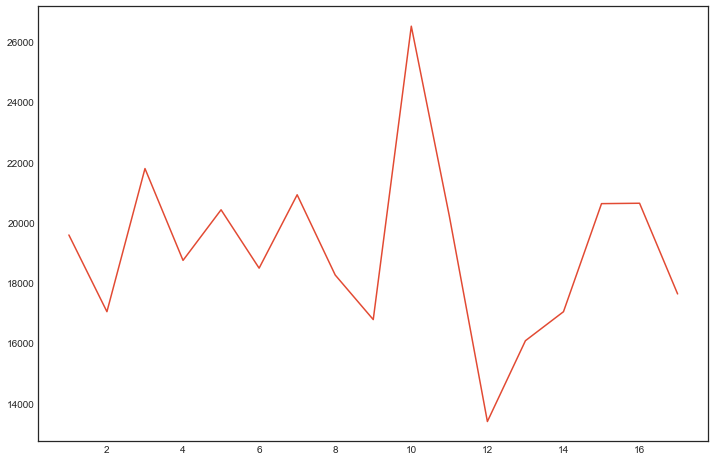

In [343]:
tmp['count'].plot()

In [339]:
tmp

,date,count
1,2014-01,19588
2,2014-02,17043
3,2014-03,21792
4,2014-04,18745
5,2014-05,20424
6,2014-06,18487
7,2014-07,20922
8,2014-08,18260
9,2014-09,16781
10,2014-10,26516


### Modell

In [132]:
af = toAuftragTable(data1, 'Modell', 'Auftragsnummer')
cv = af['Modell'].value_counts()

Falls Null date exist, drop these dates directly


In [133]:
df_vc = pd.DataFrame({'Markencode':cv.index, 'count': cv.tolist()})

In [134]:
tp = df_vc['count']

Text(0.5,0,'Modell(sotiert nach Anzahl der Auftrags)')

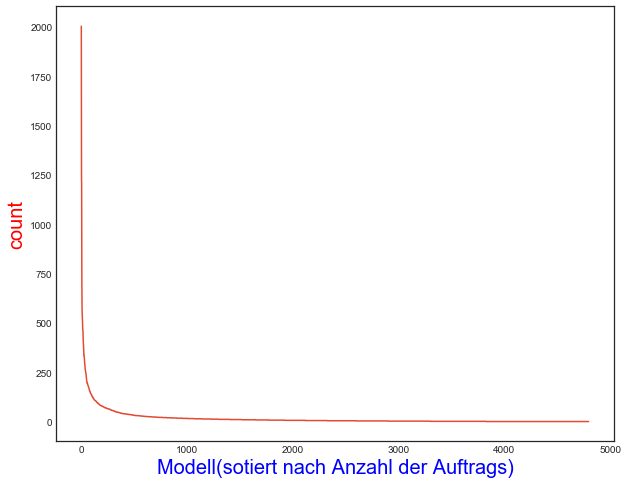

In [135]:
f, ax = plt.subplots(figsize = (10, 8))
tp.plot(ax=ax)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel('Modell(sotiert nach Anzahl der Auftrags)', fontsize=20, color='b')

In [136]:
data1['Modell'].describe()

count                             993023
unique                              4796
top       Passat Variant Comfortline BM 
freq                               19857
Name: Modell, dtype: object

In [137]:
print(df_vc[df_vc['count']<100]['count'].count()/df_vc['count'].count())
print(df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum())

0.969355847405
0.576519069166


### Motor

In [138]:
af = toAuftragTable(data1, 'Motorcode', 'Auftragsnummer')
cv = af['Motorcode'].value_counts()

Falls Null date exist, drop these dates directly


In [139]:
df_vc = pd.DataFrame({'Markencode':cv.index, 'count': cv.tolist()})

In [140]:
tp = df_vc[['count']]

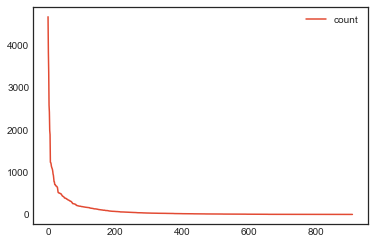

In [141]:
tp.plot()

Text(0.5,0,'Motorcode(sotiert nach Anzahl der Auftrags)')

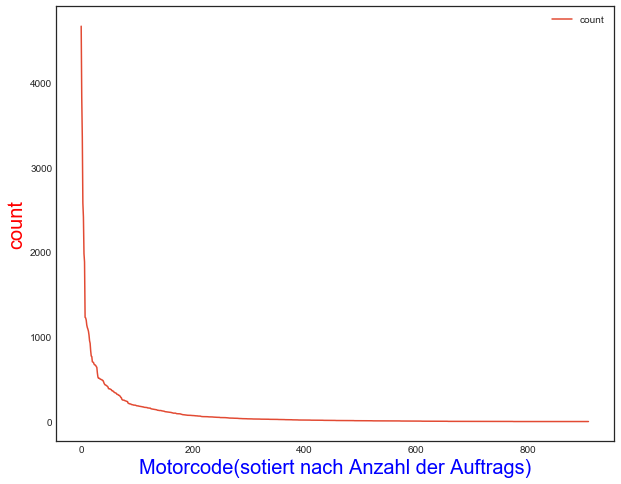

In [142]:
f, ax = plt.subplots(figsize = (10, 8))
tp.plot(ax=ax)
ax.set_ylabel('count', fontsize=20, color='r')
ax.set_xlabel('Motorcode(sotiert nach Anzahl der Auftrags)', fontsize=20, color='b')

In [143]:
df_vc

,Markencode,count
0,CFFB,4668
1,nan,3826
2,CAYC,3360
3,CRLB,2581
4,CAXA,2415
5,CBZB,1983
6,CFHC,1885
7,CFGB,1231
8,CXXB,1224
9,CBZA,1198


In [144]:
print(df_vc[df_vc['count']<100]['count'].count()/df_vc['count'].count())
print(df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum())

0.813186813187
0.149332810047


### Getriebecode

In [145]:
def draw_distribution(var):
    af = toAuftragTable(data1, var, 'Auftragsnummer')
    cv = af[var].value_counts()
    df_vc = pd.DataFrame({var:cv.index, 'count': cv.tolist()})
    tp = df_vc[['count']]
    f, ax = plt.subplots(figsize = (10, 8))
    tp.plot(ax=ax)
    ax.set_ylabel('count', fontsize=20, color='r')
    ax.set_xlabel(var+'(sotiert nach Anzahl der Auftrags)', fontsize=20, color='b')
    return df_vc

Falls Null date exist, drop these dates directly


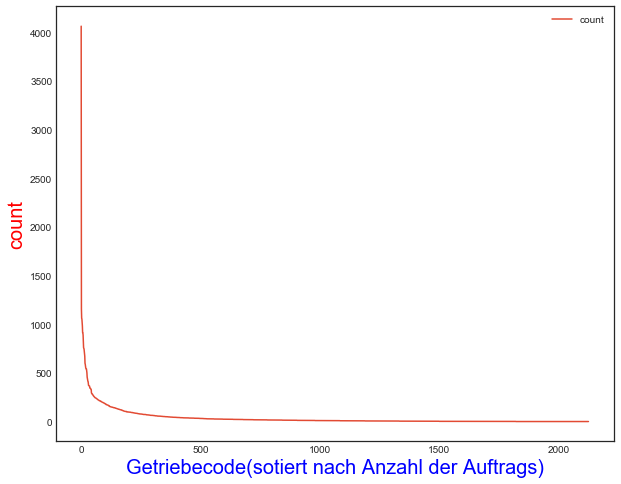

In [146]:
df_vc = draw_distribution('Getriebecode')

In [147]:
print(df_vc[df_vc['count']<100]['count'].count()/df_vc['count'].count())
print(df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum())

0.908705882353
0.366111829347


### Fahrzeugmodellnummer

Falls Null date exist, drop these dates directly


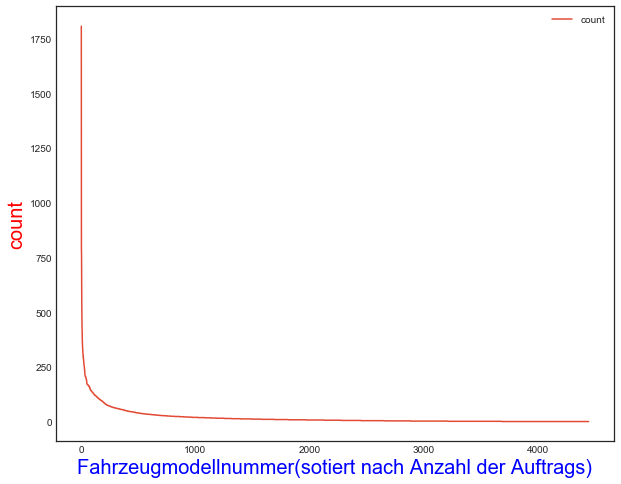

In [148]:
df_vc = draw_distribution('Fahrzeugmodellnummer')

In [149]:
print(df_vc[df_vc['count']<100]['count'].count()/df_vc['count'].count())
print(df_vc[df_vc['count']<100]['count'].sum()/df_vc['count'].sum())

0.962438146649
0.633957429125


Falls Null date exist, drop these dates directly


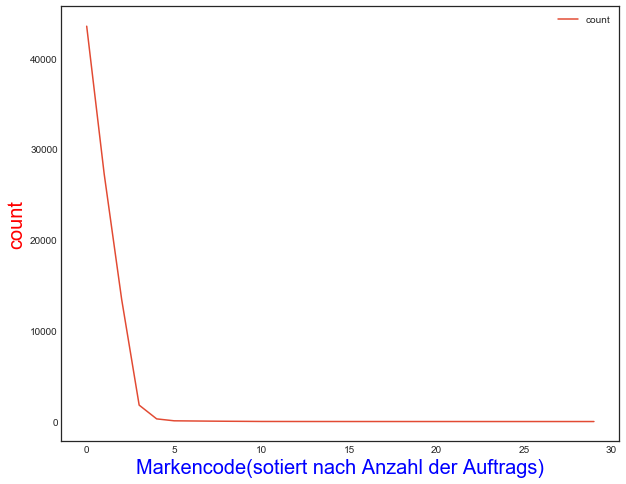

In [150]:
df_cv = draw_distribution('Markencode')

In [151]:
#df_cv

In [50]:
def draw_distribution2(data, var, n = 10, re= True):
    """only show one distribution"""
    af = toAuftragTable(data, var, 'Auftragsnummer')
    cv = af[var].value_counts()
    print(cv.count())
    target = []
    count = []
    for i in range(n):
        target.append(cv.index[i])
        count.append(cv[i])
    rest = cv.sum() - sum(count)
    if re:
        target.append('REST')
        count.append(rest)
    count = count/cv.sum()
    print('top '+str(n)+' machen ' +str(100* sum(count)*1.0/cv.sum())+ '% der Gesamtsummer aus')
    df = pd.DataFrame({'Target': target, 'count': count})
    # deop na
    df = df.drop(df[df['Target'] == 'nan'].index, axis=0)
    f, ax = plt.subplots(figsize = (14, 8))
    sns.barplot(x='Target', y='count', data=df)
    ax.set_ylabel('Propotion', fontsize=20, color='r')
    ax.set_xlabel(var, fontsize=20, color='b')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 10)
    return cv

Text(0.5,1.05,'Leonberg')

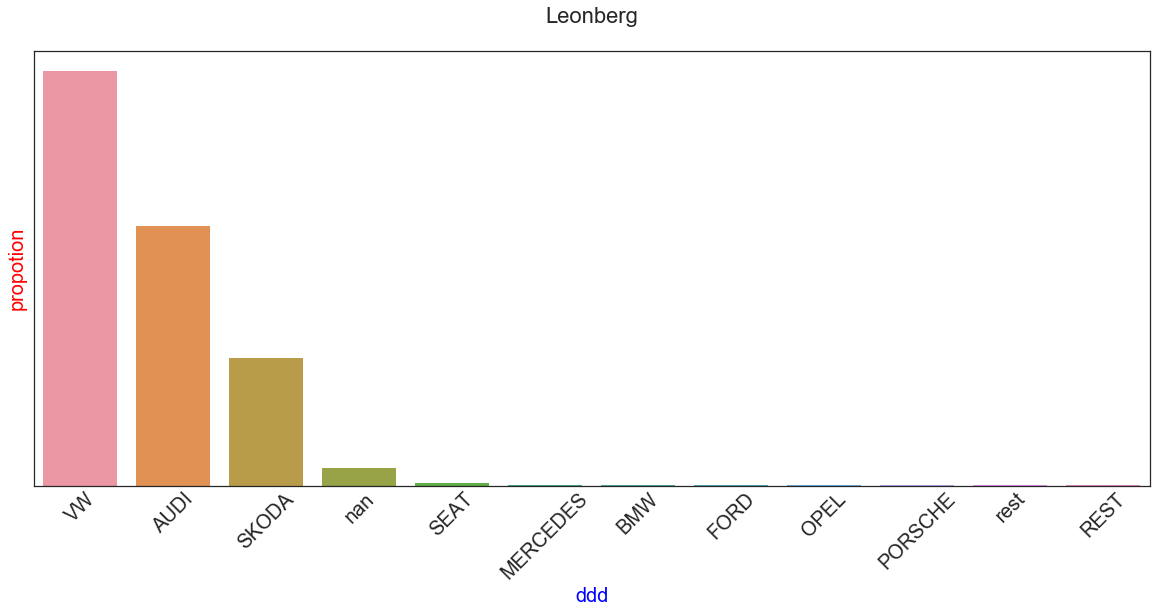

In [237]:
f, ax = plt.subplots(figsize = (20, 8))
sns.barplot(x='Target', y='count', data=df)
ax.set_ylabel('propotion', fontsize=20, color='r')
ax.set_xlabel('ddd', fontsize=20, color='b')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 20)
ax.set_title('Leonberg', fontsize=22, position=(0.5,1.05))

Falls Null date exist, drop these dates directly


,Target,count
0,VW,43531
1,AUDI,27261
2,SKODA,13444
3,REST,2396


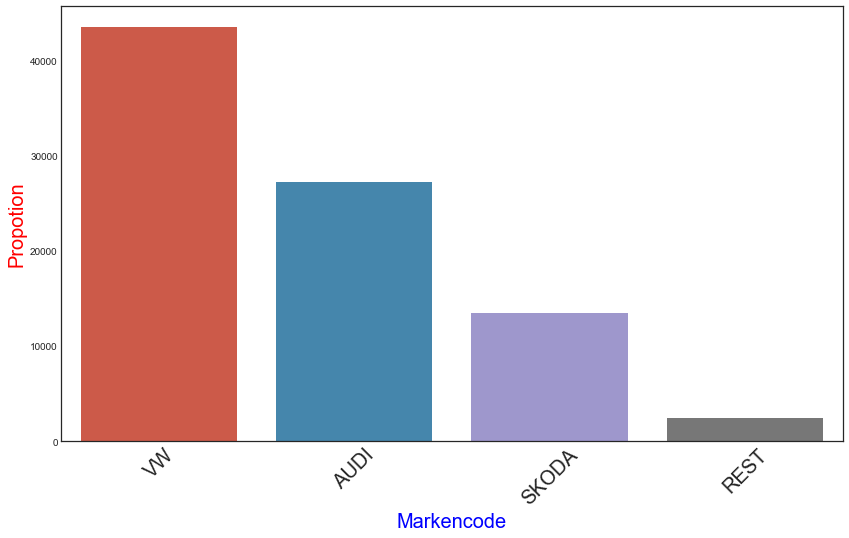

In [216]:
draw_distribution2(data1, 'Markencode', 3)

Falls Null date exist, drop these dates directly


,Target,count
0,VW,108766
1,AUDI,51539
2,SKODA,20273
3,REST,12669


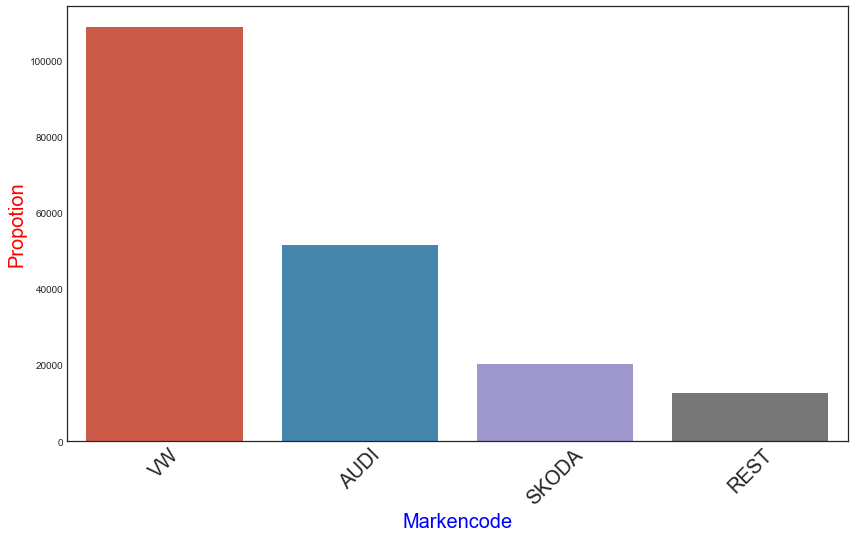

In [221]:
draw_distribution2(data2, 'Markencode', 3)

In [238]:
def draw_distribution3(data1, data2, var, n = 10):
    """compare two datasets: leonberg and weil"""
    af = toAuftragTable(data1, var, 'Auftragsnummer')
    cv = af[var].value_counts()
    print(cv.count())
    target = []
    count = []
    for i in range(n):
        target.append(cv.index[i])
        count.append(cv[i])
    rest = cv.sum() - sum(count)
    print('top '+str(n)+' machen ' +str(100* sum(count)*1.0/cv.sum())+ '% der Gesamtsummer aus')
    target.append('REST')
    count.append(rest)
    count = count/cv.sum()
    df1 = pd.DataFrame({'Target': target, 'count': count})
    af = toAuftragTable(data2, var, 'Auftragsnummer')
    cv = af[var].value_counts()
    print(cv.count())
    target = []
    count = []
    for i in range(n):
        target.append(cv.index[i])
        count.append(cv[i])
    rest = cv.sum() - sum(count)
    print('top '+str(n)+' machen ' +str(100* sum(count)*1.0/cv.sum())+ '% der Gesamtsummer aus')
    target.append('REST')
    count.append(rest)
    count = count/cv.sum()
    df2 = pd.DataFrame({'Target': target, 'count': count})
    df1['Autohaus'] = 'Leonberg'
    df2['Autohaus'] = 'Weil'
    df = pd.concat([df1, df2], axis=0)
    f, ax = plt.subplots(figsize = (14, 8))
    sns.barplot(x='Target', y='count', data=df, hue='Autohaus')
    ax.set_ylabel('Propotion', fontsize=20, color='r')
    ax.set_xlabel(var, fontsize=20, color='b')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 20)
    return df

Falls Null date exist, drop these dates directly
30
top 3 machen 97.1807294447% der Gesamtsummer aus
Falls Null date exist, drop these dates directly
43
top 3 machen 93.4441414356% der Gesamtsummer aus


,Target,count,Autohaus
0,VW,0.499683,Leonberg
1,AUDI,0.313736,Leonberg
2,SKODA,0.158389,Leonberg
3,REST,0.028193,Leonberg
0,VW,0.562834,Weil
1,AUDI,0.266700,Weil
2,SKODA,0.104907,Weil
3,REST,0.065559,Weil


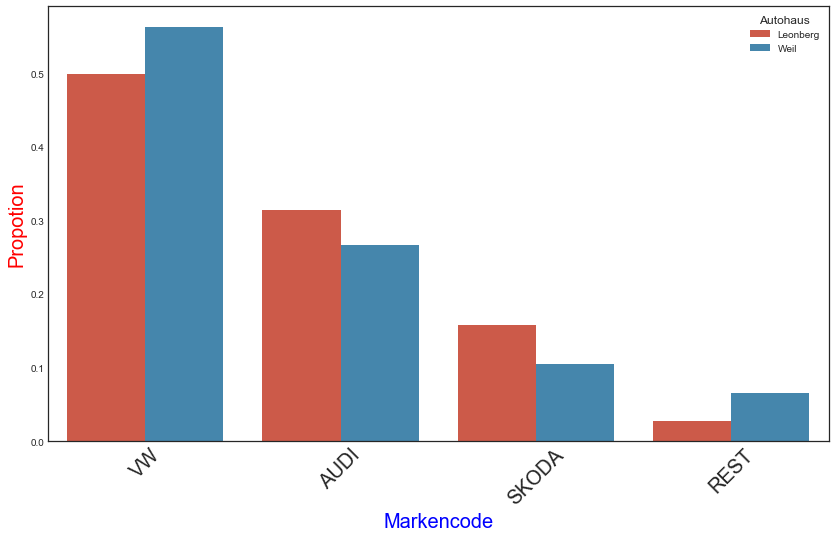

In [239]:
draw_distribution3(data1, data2, 'Markencode', n = 3)

Falls Null date exist, drop these dates directly
958
top 10 machen 27.5128171553% der Gesamtsummer aus
Falls Null date exist, drop these dates directly
1179
top 10 machen 27.8446754671% der Gesamtsummer aus


,Target,count,Autohaus
0,CFFB,0.050251,Leonberg
1,nan,0.046343,Leonberg
2,CAYC,0.036120,Leonberg
3,CRLB,0.031637,Leonberg
4,CAXA,0.026793,Leonberg
5,CBZB,0.022109,Leonberg
6,CFHC,0.020578,Leonberg
7,CXXB,0.014897,Leonberg
8,CBZA,0.013215,Leonberg
9,CFGB,0.013185,Leonberg


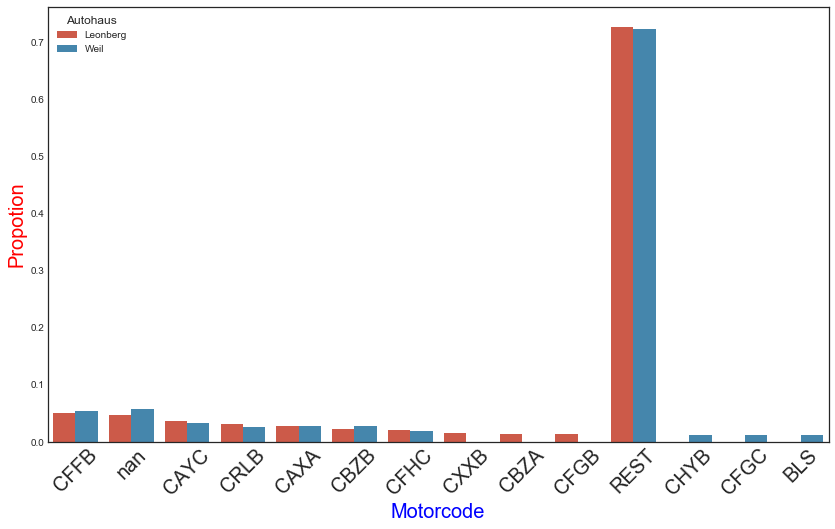

In [240]:
draw_distribution3(data1,data2, 'Motorcode', n = 10)

Falls Null date exist, drop these dates directly
5109
top 10 machen 10.9577864848% der Gesamtsummer aus
Falls Null date exist, drop these dates directly
9231
top 10 machen 9.46405377574% der Gesamtsummer aus


,Target,count,Autohaus
0,nan,0.022119,Leonberg
1,Passat Variant Comfortline BM,0.016841,Leonberg
2,Golf Comfortline BlueMotion Te,0.015018,Leonberg
3,Passat Variant Comfortline,0.013306,Leonberg
4,Touran Comfortline BlueMotion,0.008441,Leonberg
5,VW Golf IV > 98 / Variant > 99,0.007806,Leonberg
6,Transporter Kasten Radstand: 3,0.006658,Leonberg
7,Caddy Trendline 5-Sitzer,0.006567,Leonberg
8,"Octavia Combi Elegance 2,0l 11",0.006416,Leonberg
9,Caddy Kastenwagen Radstand: 26,0.006406,Leonberg


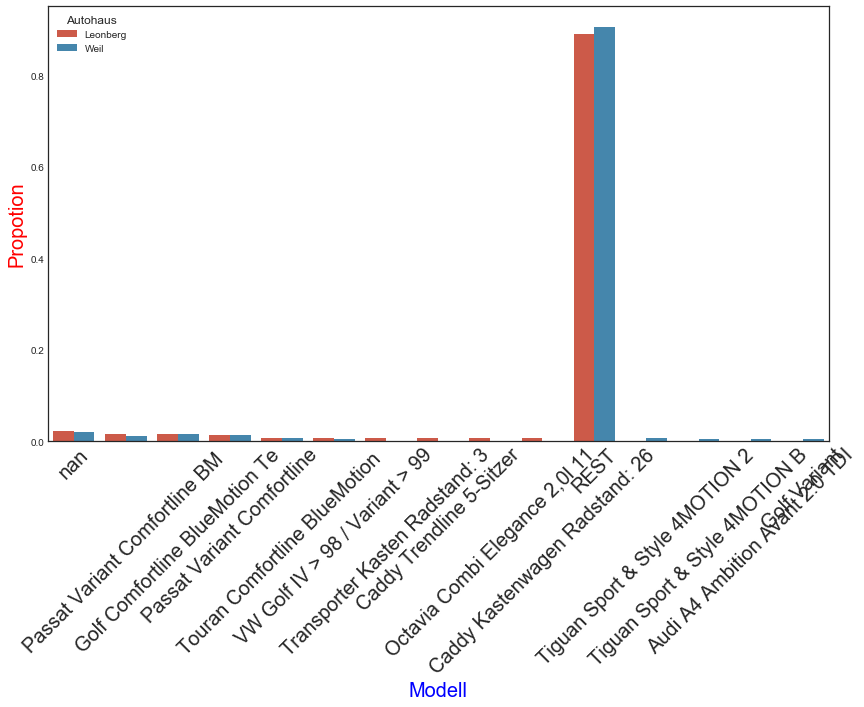

In [241]:
draw_distribution3(data1, data2, 'Modell', n = 10)

Falls Null date exist, drop these dates directly
70486
top 10 machen 2.84783361431e-05% der Gesamtsummer aus


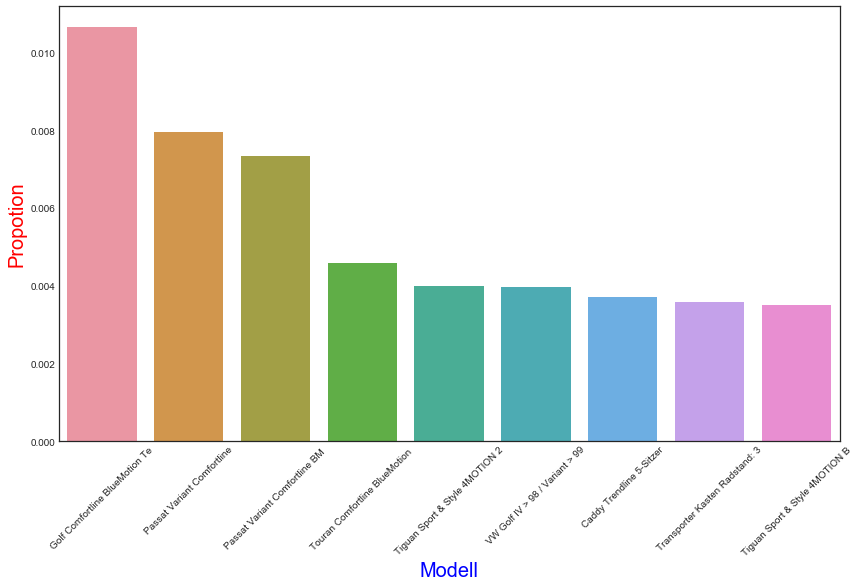

In [38]:
df = draw_distribution2(data, 'Modell', n = 10, re = False)

In [39]:
df

,Target,count
1,Golf Comfortline BlueMotion Te,0.010661
2,Passat Variant Comfortline,0.007946
3,Passat Variant Comfortline BM,0.007346
4,Touran Comfortline BlueMotion,0.004578
5,Tiguan Sport & Style 4MOTION 2,0.003987
6,VW Golf IV > 98 / Variant > 99,0.003969
7,Caddy Trendline 5-Sitzer,0.003718
8,Transporter Kasten Radstand: 3,0.003588
9,Tiguan Sport & Style 4MOTION B,0.003494


Falls Null date exist, drop these dates directly
27843
top 10 machen 8.64282287768e-05% der Gesamtsummer aus


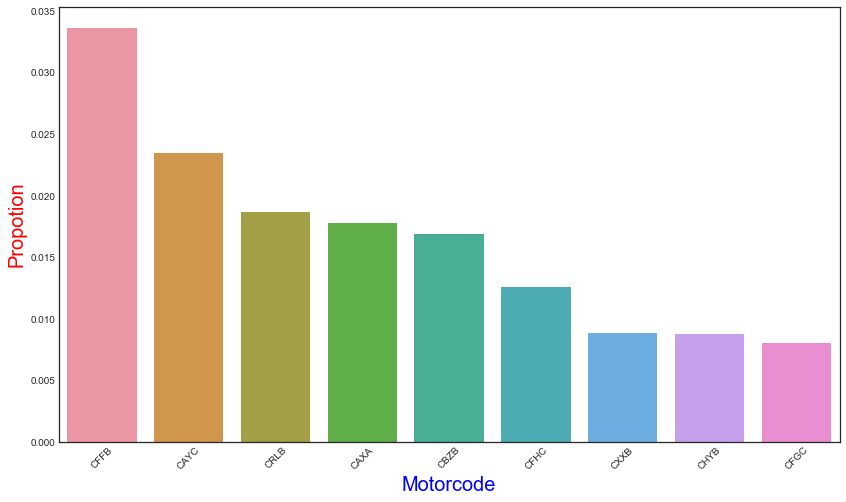

In [51]:
cv = draw_distribution2(data, 'Motorcode', n = 10, re = False)

In [41]:
cv.sum()

3322918

In [6]:
58812/3322918

0.017698901989155316

In [8]:
data[data['Modell'].isna()].count()

Auftragsnummer          27197
AW-Nr                    9215
Teile-Nr                16634
KM-Stand                27042
Beschreibung            27122
Auftragsdatum           27197
Markencode              15506
Lagerortcode            27192
Adressanredecode        26479
Fahrgestellnummer       17806
Motorcode                7029
Fahrzeugmodellnummer    15490
Modell                      0
Typ                       791
Getriebecode             6867
Getriebeartcode           401
Gewicht                 15490
Leistung (KW)           15490
Erstzulassungsdatum     15490
Neuwagen                14489
Unnamed: 20                 0
dtype: int64

In [28]:
df[df['Target'] == 'nan'].index

Int64Index([0], dtype='int64')

In [33]:
df.drop(df[df['Target'] == 'nan'].index, axis=0)

,Target,count
1,Golf Comfortline BlueMotion Te,0.010661
2,Passat Variant Comfortline,0.007946
3,Passat Variant Comfortline BM,0.007346
4,Touran Comfortline BlueMotion,0.004578
5,Tiguan Sport & Style 4MOTION 2,0.003987
6,VW Golf IV > 98 / Variant > 99,0.003969
7,Caddy Trendline 5-Sitzer,0.003718
8,Transporter Kasten Radstand: 3,0.003588
9,Tiguan Sport & Style 4MOTION B,0.003494


In [49]:
df

,Target,count
1,CFFB,0.033663
2,CAYC,0.023472
3,CRLB,0.018724
4,CAXA,0.017841
5,CBZB,0.016950
6,CFHC,0.012632
7,CXXB,0.008829
8,CHYB,0.008780
9,CFGC,0.008090


In [52]:
cv

nan            9815
CFFB           7515
CAYC           5240
CRLB           4180
CAXA           3983
CBZB           3784
CFHC           2820
CXXB           1971
CHYB           1960
CFGC           1806
CFGB           1773
CBZA           1720
BLS            1706
CZCA           1606
CGL            1568
CHYA           1420
CLHA           1371
CAYD           1365
BSE            1300
CUNA           1240
CNH            1199
CYVB           1198
CJZC           1198
CZDA           1194
CNHA           1163
CBAB           1131
CAY            1105
BMM            1094
CRBC           1094
CAAC           1047
               ... 
BSE;ALH           1
CBZA;CDLJ         1
BUD;DFEA          1
CHHA;CXGB         1
BMD;BRU           1
CJZC;A14NEL       1
AWY;CLHA          1
CBZB;AEK          1
CGGB;CGW          1
CRT;CTFA          1
AZD;CGQ           1
CJS;CJZC          1
CANC;CGKA         1
CUSA;AZJ          1
BDG;CGW           1
CLA;DLBA          1
DETA;CUN          1
BMK;CJG           1
AVQ;CFF           1
